# 👀 다층 퍼셉트론 (MLP)

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/02_deeplearning/01_mlp/mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

이 노트북에서는 CIFAR 데이터셋에서 다층 퍼셉트론을 훈련합니다.

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks

--2023-11-09 03:21:34--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2023-11-09 03:21:35 (37.5 MB/s) - ‘utils.py’ saved [771/771]



In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras import layers, models, optimizers, utils, datasets
from notebooks.utils import display

## 0. 파라미터 <a name="parameters"></a>

In [2]:
NUM_CLASSES = 10

## 1. 데이터 준비 <a name="prepare"></a>

In [3]:
# 텐서 데이터는 x, y, z, channel 순서로 축을 가진다고 생각하면 된다.
# (batch_size, height, width, channels)

(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
# [50000, 32, 32, 3] 크기의 훈련 데이터 (X)
# [50000, 1] 크기의 훈련 레이블 (Y)

# [10000, 32, 32, 3] 크기의 테스트 데이터 (X)
# [10000, 1] 크기의 테스트 레이블 (Y)

In [4]:
# 픽셀 채널 값이 0과 1사이가 되도록 이미지의 스케일을 조절한다.
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# 레이블을 원-핫 인코딩으로 변환한다. (10000, 1) -> (10000, 10)
# 여기서 원-핫 인코딩이란, 0부터 9까지의 정수형 레이블을 10개의 이진 벡터로 변환하는 것을 말한다.
y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_test = utils.to_categorical(y_test, NUM_CLASSES)

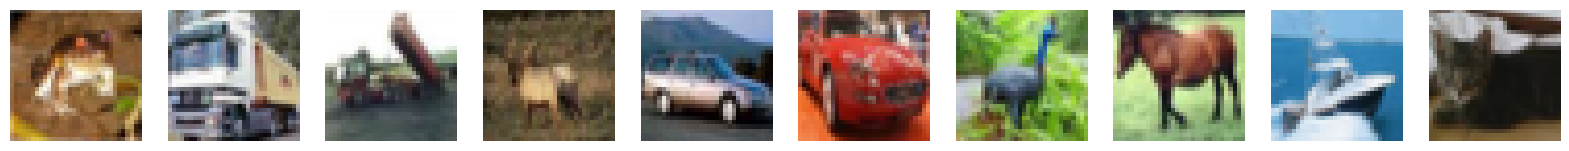

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [5]:
display(x_train[:10])
print(y_train[:10])

## 2. 모델 구축 <a name="build"></a>

In [6]:
# Input, Flatten, Dense 총 3개의 layer를 사용함.
# Input Layer는 네트워크의 시작점, 네트워크가 기대하는 입력 데이터의 크기를 튜플로 알려주어야 함, 배치 크기는 제외하고 (32, 32, 3)을 입력으로 받음. 임의의 갯수의 이미지를 입력으로 받을 수 있다.
# Flatten Layer는 3차원의 이미지를 1차원으로 펼쳐줌. (32, 32, 3) -> (3072, )
# 뒤따르는 Dense Layer가 다차원 배열이 아니라 1차원 배열을 입력으로 받기 때문에 필요함. (다른 종류의 Layer는 다차원 배열을 입력으로 받을 수 있음)
# 따라서 Flatten Layer를 사용하기 위해서는 층마다 필요한 입력과 출력의 크기를 알아야 한다.
# Dense는 기본적인 신경망 구성 요소임. Fully Connected되는 Layer를 의미함. 연결마다 하나의 가중치가 동반된다. 출력은 이전층에서 받은 입력과 가중치를 곱하여 더한 것이다.
# 그 다음 활성화 함수를 통과시킨다. 여기서는 relu를 사용함.
# ReLU는 입력이 0보다 크면 입력을 그대로 출력하고, 0보다 작으면 0을 출력함. 이를 통해 음수를 0으로 만들어주어 음수가 아닌 값만 출력되도록 함.
# LeakyReLU는 relu와 비슷하지만, 입력이 0보다 작을 때 0이 아닌 작은 값을 출력함. 이를 통해 입력이 음수일 때도 0이 아닌 값을 출력할 수 있음.
# Sigmoid는 입력을 0과 1 사이의 값으로 변환함. 이진 분류 문제에서 출력층에 사용됨.
# Softmax는 입력을 0과 1 사이의 값으로 변환하고, 모든 출력의 합이 1이 되도록 함. 다중 클래스 분류 문제에서 출력층에 사용됨.
input_layer = layers.Input((32, 32, 3))

x = layers.Flatten()(input_layer)
x = layers.Dense(200, activation="relu")(x)
x = layers.Dense(150, activation="relu")(x)

output_layer = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(input_layer, output_layer)

model.summary()
# Input의 크기는 x_train과 같아야하고, Output의 크기는 y_train과 같아야 한다.
# Summery에는 각 층의 이름, 출력의 크기, 파라미터(훈련될 가중치)의 갯수가 표시된다.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 200)               614600    
                                                                 
 dense_1 (Dense)             (None, 150)               30150     
                                                                 
 dense_2 (Dense)             (None, 10)                1510      
                                                                 
Total params: 646260 (2.47 MB)
Trainable params: 646260 (2.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 3. 모델 훈련 <a name="train"></a>

In [7]:
opt = optimizers.Adam(learning_rate=0.0005)
model.compile(
    loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)
# Loss function은 모델이 최적화하려는 값이다. 모델이 예측한 값과 실제 값의 차이를 계산한다. 0에 가까울수록 좋은 모델이다.
# Keras가 제공하는 Loss Function은 다음과 같다.
# mean_squared_error(평균 제곱 오차 손실), categorical_crossentropy(범주형 크로스 엔트로피), binary_crossentropy(이진 크로스 엔트로피)
# regresstion문제를 풀 때에는 mean_squared_error
# 여러 클래스 중 하나에 속하는 분류 문제라면 categorical_crossentropy
# 출력 유닛이 하나인 이진 분류 문제, 샘플이 여러 클레스에 속할 수 있는 다중 레이블 분류 문제라면 binary_crossentropy

# Optimizer는 모델이 손실을 최소화하기 위해 가중치를 업데이트하는 방법을 정의한다. Adam은 RMSProp과 Momentum을 합친 것이다.
# Adam은 learning_rate를 제외하면 굳이 매개변수를 바꿀 필요가 없다.

# 널리 사용하는 Optimizer는 RMSProp이다. https://keras.io/api/optimizers/rmsprop/ 에서 자세한 내용을 확인할 수 있다.

In [8]:
model.fit(x_train, y_train, batch_size=32, epochs=10, shuffle=True)
# batch_size는 훈련 스텝마다 네트워크에 전달될 샘플의 개수
# epochs는 전체 훈련 데이터를 반복하는 횟수
# shuffle=True면 훈련 스텝마다 배치를 중복을 허용하지 않고 랜덤하게 추출함

# 훈련과정은 다음과 같음
# 네트워크의 가중치를 작고 랜덤한 값으로 초기화 한다.
# 훈련 스텝마다 한 이미지 배치가 네트워크를 통과하고 오차가 역전파되어 가중치가 업데이트된다.
# batch_size는 훈련스텝마다 몇개의 이미지로 배치를 만들지 결정한다.
# batch_size가 너무 크면 네트워크가 한 번에 처리해야 하는 데이터가 많아지므로 훈련이 느려진다. 하지만 gradient계산은 안정적이게 된다.
# 모든 데이터셋의 샘플이 사용되면 1 epoch가 끝난다.

Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.8392 - accuracy: 0.3395
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6671 - accuracy: 0.4042
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5847 - accuracy: 0.4352
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5355 - accuracy: 0.4520
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4939 - accuracy: 0.4690
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4611 - accuracy: 0.4765
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4367 - accuracy: 0.4875
Epoch 8/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4101 - accuracy: 0.4985
Epoch 9/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3863 - accuracy: 0.5054
Epoch 10/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.364

## 4. 평가 <a name="evaluate"></a>

In [9]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 760us/step - loss: 1.4602 - accuracy: 0.4843


[1.4602326154708862, 0.48429998755455017]

In [10]:
# predict 메소드를 사용해 테스트 셋에 대한 예측을 만들 수 있다.
CLASSES = np.array(
    [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
)

# [10000, 10]크기의 배열로 샘플마다 10개의 클래스에 대한 확률을 담고 있다.
preds = model.predict(x_test)
# 이 확률 배열을 argmax를 사용해 하나의 예측 결과로 바꾼다. axis=-1은 마지막 차원으로 배열을 압축하라는 뜻이다.
# 그 결과로 [10000, 1] 크기의 배열이 만들어진다.
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

313/313 [==============================] - 0s 676us/step


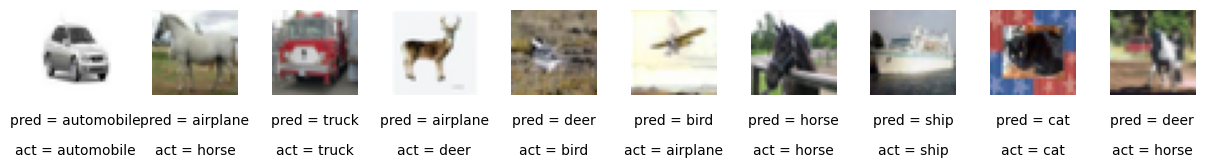

In [13]:
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# 무작위로 선택해서 예측값과 실제 값을 출력한다.
for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + str(preds_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + str(actual_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)